In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

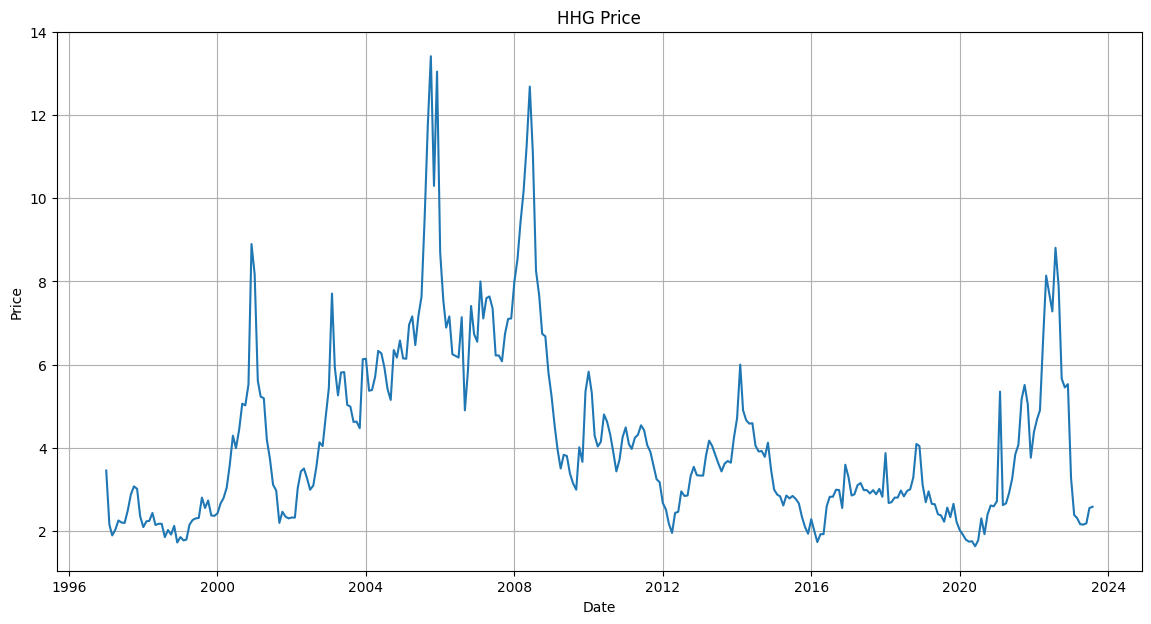

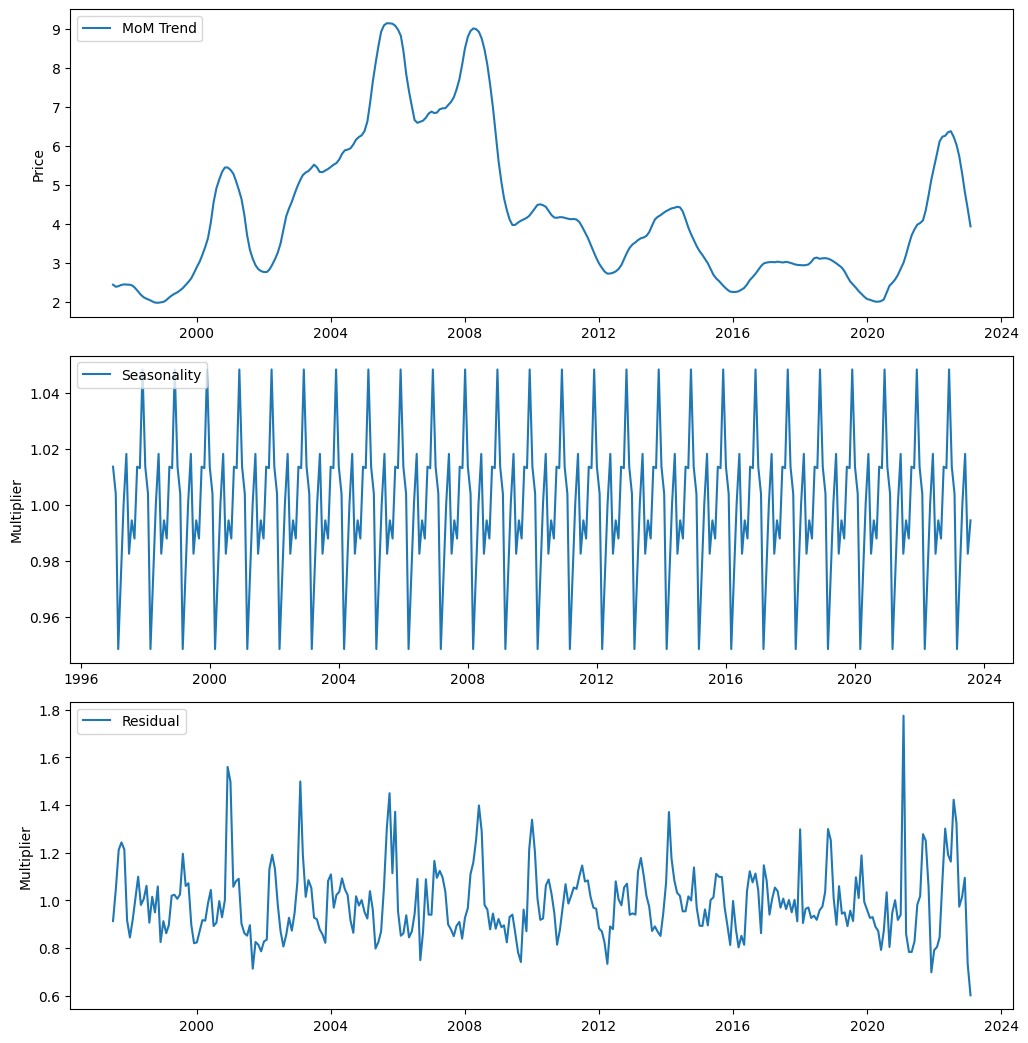

In [256]:
data = pd.read_csv(r'C:\Users\keyan\Downloads\HH NG spot price MONTH.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')
data.set_index('Date', inplace=True)

plt.figure(figsize=(14,7))
plt.plot(data['Henry Hub Natural Gas Spot Price '])
data.rename(columns={'Henry Hub Natural Gas Spot Price ': 'Price'}, inplace=True)
plt.title('HHG Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Decompose seasonal and long term trend using multiplicative model
decomposition_multiplicative = seasonal_decompose(data['Price'], model='multiplicative')
trend_multiplicative = decomposition_multiplicative.trend
seasonal_multiplicative = decomposition_multiplicative.seasonal
residual_multiplicative = decomposition_multiplicative.resid

plt.figure(figsize=(20,14))

plt.subplot(423)
plt.plot(trend_multiplicative, label='MoM Trend')
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.subplot(425)
plt.plot(seasonal_multiplicative, label='Seasonality')
plt.ylabel('Multiplier')
plt.legend(loc='upper left')

plt.subplot(427)
plt.plot(residual_multiplicative, label='Residual')
plt.ylabel('Multiplier')
plt.legend(loc='upper left')

plt.tight_layout()

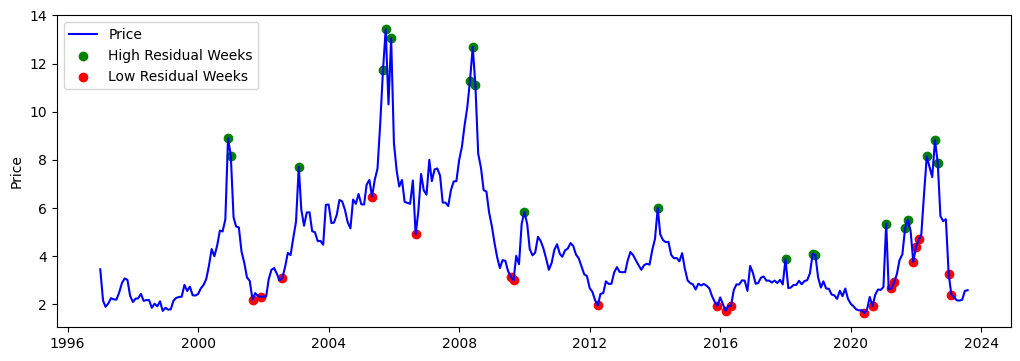

In [253]:
# find most extreme residual weeks
highest_residual_dates = residual_multiplicative.sort_values(ascending=False).head(20).index
highest_residual_values = residual_multiplicative.sort_values(ascending=False).head(20).values

lowest_residual_dates = residual_multiplicative.sort_values(ascending=True).head(20).index
lowest_residual_values = residual_multiplicative.sort_values(ascending=True).head(20).values

plt.figure(figsize=(20,14))

# plot price with extreme price residuals highlighted
plt.subplot(421)
plt.plot(data['Price'], label='Price', color='blue')
plt.scatter(highest_residual_dates, data['Price'].loc[highest_residual_dates], color='green', label='High Residual Weeks')
plt.scatter(lowest_residual_dates, data['Price'].loc[lowest_residual_dates], color='red', label='Low Residual Weeks')
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.tight_layout()



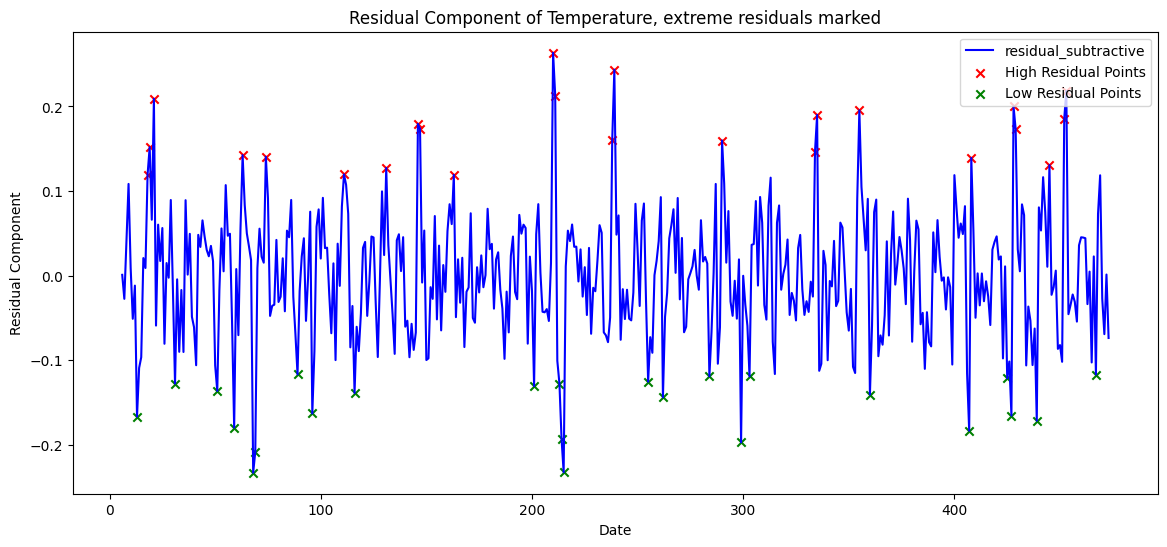

<Figure size 640x480 with 0 Axes>

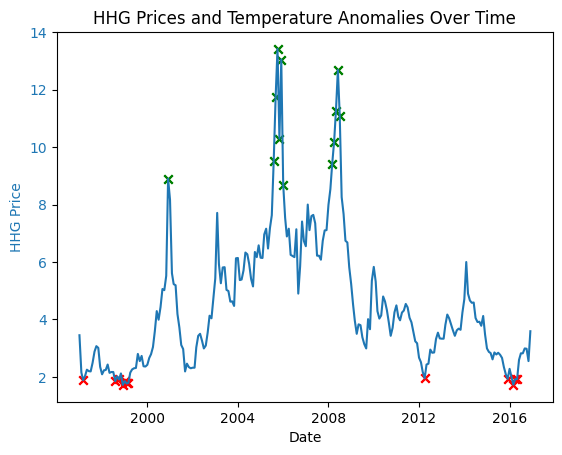

In [252]:
high_residual_points = merged_df[merged_df['Residual'] > merged_df['Residual'].quantile(0.95)]
low_residual_points = merged_df[merged_df['Residual'] < merged_df['Residual'].quantile(0.05)]
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()

residual_subtract = temp_df['Temp_Anomaly'].loc[seasonal.index] - (seasonal + trend)

high_residual_points_subtract = residual_subtract[residual_subtract > residual_subtract.quantile(0.95)]
low_residual_points_subtract = residual_subtract[residual_subtract < residual_subtract.quantile(0.05)]

plt.figure(figsize=(14, 6))
plt.plot(residual_subtract, label='residual_subtractive', color='blue')
plt.scatter(high_residual_points_subtract.index, high_residual_points_subtract, color='red', label='High Residual Points',marker='x')
plt.scatter(low_residual_points_subtract.index, low_residual_points_subtract, color='green', label='Low Residual Points',marker='x')
plt.xlabel('Date')
plt.ylabel('Residual Component')
plt.title('Residual Component of Temperature, extreme residuals marked')
plt.legend()
plt.show()

plt.tight_layout()

hhg_df = hhg_df[hhg_df['Date_HHG'] >= '1995-01-01']
temp_df = temp_df[temp_df['Date_Temp'] >= '1995-01-01']
merged_df = pd.merge(hhg_df, temp_df, left_on='Date_HHG', right_on='Date_Temp', how='inner')

merged_df = merged_df[merged_df['Date_HHG'] >= '1995-01-01']
merged_df = merged_df[merged_df['Date_Temp'] >= '1995-01-01']
merged_df['Residual'] = merged_df['HHG_Price'] - merged_df['HHG_Price'].mean()

high_residual_points = merged_df[merged_df['Residual'] > merged_df['Residual'].quantile(0.95)]
low_residual_points = merged_df[merged_df['Residual'] < merged_df['Residual'].quantile(0.05)]

fig, ax1 = plt.subplots()
ax1.set_xlabel('Date')
ax1.set_ylabel('HHG Price', color='tab:blue')
ax1.plot(merged_df['Date_HHG'], merged_df['HHG_Price'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.scatter(high_residual_points['Date_HHG'], high_residual_points['HHG_Price'], color='green',marker='x')
ax1.scatter(low_residual_points['Date_HHG'], low_residual_points['HHG_Price'], color='red',marker='x')
plt.title('HHG Prices and Temperature Anomalies Over Time')
plt.show()

In [255]:
from scipy.stats import spearmanr

# reload csv's for re-format 
temp_df = pd.read_csv(r'C:\Users\keyan\Downloads\monthly (1).csv')
temp_df = temp_df.rename(columns={'Date': 'Date_Temp', 'Mean': 'Temp_Anomaly'})
temp_df['Date_Temp'] = pd.to_datetime(temp_df['Date_Temp'], format='%Y-%m')
hhg_df = pd.read_csv(r'C:\Users\keyan\Downloads\HH NG spot price MONTH.csv')
hhg_df.columns = hhg_df.columns.str.strip()
hhg_df = hhg_df.rename(columns={'Date': 'Date_HHG', 'Henry Hub Natural Gas Spot Price': 'HHG_Price'})
hhg_df['Date_HHG'] = pd.to_datetime(hhg_df['Date_HHG'], format='%b-%y')  
hhg_df['Date_HHG'] = hhg_df['Date_HHG'].dt.to_period('M').dt.to_timestamp() 

trend_temp = temp_df['Temp_Anomaly'].rolling(window=12, center=True).mean()
trend_temp = trend_temp.interpolate(method='linear')  
seasonal_temp = seasonal_decompose(temp_df['Temp_Anomaly'], period=12).seasonal
temp_residual = temp_df['Temp_Anomaly'] - (trend_temp + seasonal_temp)

price_residual = hhg_df['HHG_Price'] - hhg_df['HHG_Price'].mean()
price_residual = price_residual.dropna()

aligned_data = pd.DataFrame({
    'Temp_Residual': temp_residual,
    'Price_Residual': price_residual
}).dropna()

temp_upper = aligned_data['Temp_Residual'].quantile(0.8)
price_upper = aligned_data['Price_Residual'].quantile(0.8)

extreme_residuals = aligned_data[
    (aligned_data['Temp_Residual'] > temp_upper) &
    (aligned_data['Price_Residual'] > price_upper)
]
extreme_residuals.to_csv(r'C:\Users\keyan\Downloads\extreme_residuals.csv', index=False)


Spearman Correlation of Local Extrema Residual Points: 0.5618964003511853, P-value: 0.01228735123371251


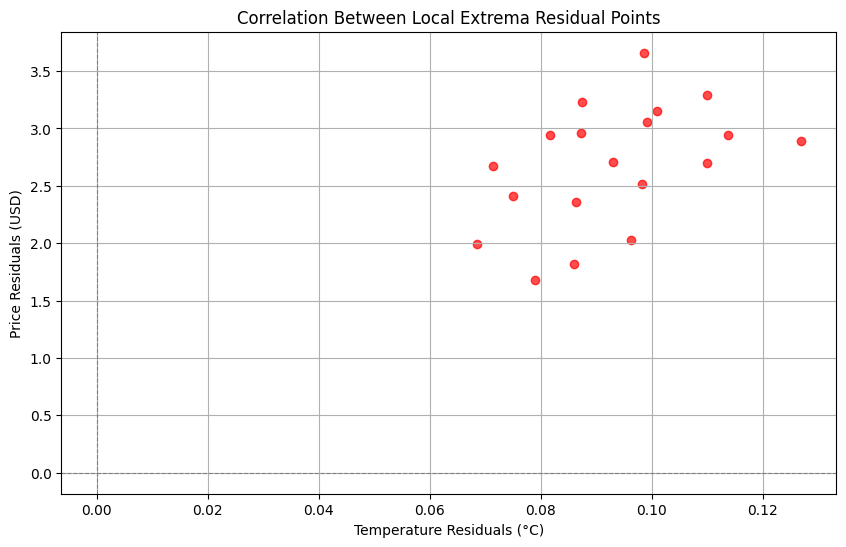

In [230]:
top_residuals_loaded = pd.read_csv(r'C:\Users\keyan\Downloads\extreme_residuals.csv')
corr_top_csv, p_value_top_csv = spearmanr(
    top_residuals_loaded['Temp_Residual'],
    top_residuals_loaded['Price_Residual']
        )
print(f"Spearman Correlation of Local Extrema Residual Points: {corr_top_csv}, P-value: {p_value_top_csv}")

plt.figure(figsize=(10, 6))
plt.scatter(top_residuals_loaded['Temp_Residual'], top_residuals_loaded['Price_Residual'], alpha=0.7, color='red')
plt.title('Correlation Between Local Extrema Residual Points')
plt.xlabel('Temperature Residuals (\u00b0C)')
plt.ylabel('Price Residuals (USD)')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.show()